# MOOC User Action Dataset Pipeline: FIGRL test

In [1]:
#!pip install FastInductiveGraphRepresentationLearning

In [2]:
import FastInductiveGraphRepresentationLearning 
from FastInductiveGraphRepresentationLearning import FIGRL

The dataset used in this experiment can be downloaded through te following link:
http://snap.stanford.edu/data/act-mooc.html

Before the pipeline for the Stanford Wikipedia dataset kicks off, some global parameters need to be defined. 
The `embedding_size`defines the dimension of the embeddings learned by Fast Inductive Graph Representation Learning algorithm. The `intermediate_dimension` is given by choosing an appropriate approximation ratio by the following formula: `intermediate_dimension` = max{4log(amount of nodes)/e^2, k/e^2} with e the approximation ratio and k the final embeddings_size.

In [3]:
# Global parameters:
embedding_size = 40
intermediate_dimension = 400

## 1. Loading the MOOC Dataset

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import numpy as np
import networkx as nx

The action file has following attributes:

ACTIONID: a unique id for each action.

USERID: a unique id for each user.

TARGETID: a unique id for each target activity.

TIMESTAMP: timestamp for the action in seconds from the beginning.

In [5]:
df_action = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\FIGRL_Uit_Matlab\\datasets\\mooc_actions.tsv", sep='\t')

df_action = df_action.set_index('ACTIONID')
pd.Series(df_action.index).is_unique

True

The feature file has following attributes:

ACTIONID: a unique id for each action.

FEATUREx: a feature value associated with the action. Total four in count, making it a 4-dimensional feature vector

In [6]:
df_feature = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\datasets\\mooc_action_features.tsv", sep='\t')

df_feature = df_feature.set_index('ACTIONID')
pd.Series(df_feature.index).is_unique

True

The lable file has following attributes:
    
ACTIONID: a unique id for each action.
    
LABEL: a binary label indicating whether the student drops-out after the action. The value is 1 for drop-out actions, 0 otherwise.

In [7]:
df_labels = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\datasets\\mooc_action_labels.tsv", sep='\t')
df_labels = df_labels.drop(columns='ACTIONID')
df_labels.index.name = 'ACTIONID'

pd.Series(df_labels.index).is_unique

True

In [8]:
df = pd.merge(df_action, df_feature.loc[df_action.index], left_index=True, right_index=True)
df = pd.merge(df, df_labels.loc[df.index], left_index=True, right_index=True)
pd.Series(df.index).is_unique

True

All nodes in the FI-GRL network need to be transformed in sequential node IDs. FI-GRL uses matrix location to define the embedding.

In [9]:
df['USERID']+=max(df.index)+1
df['TARGETID']+=max(df.USERID)+1
print(min(df.TARGETID))

418796


The dataset is divided into a training set and an inductive set.

In [10]:
cutoff = round(0.6*len(df))
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

The training set and inductive set have following 

In [11]:
print('The distribution of negative actions for the train data is:\n', train_data['LABEL'].value_counts())
print('The distribution of negative actions for the inductive data is:\n', inductive_data['LABEL'].value_counts())

The distribution of negative actions for the train data is:
 0    244461
1      2588
Name: LABEL, dtype: int64
The distribution of negative actions for the inductive data is:
 0    163222
1      1478
Name: LABEL, dtype: int64


### 1.1 Undersampling

Sampling in this imbalanced set can be usefull

In [12]:
undersampling_rate = None

In [13]:
from imblearn.under_sampling import RandomUnderSampler

if not undersampling_rate is None:
    print("An undersampling rate of ", undersampling_rate, "is applied.")
    train_data['index'] = train_data.index
    undersample = RandomUnderSampler(sampling_strategy=(undersampling_rate))
    X, y = undersample.fit_resample(train_data, train_data['state_label'])
    train_data = X.set_index(X['index']).drop('index',axis=1)
    print('The new distribution for the train set is:\n', train_data["state_label"].value_counts())

## 2. Construct the Graph Network

A networkx graph is constructed with actions, users and target nodes. Creating a three partite graph. The FI-GRL framework derives embeddings starting from an adjacency matrix that it constructs using the graph's edgelist. 

In [14]:
nodes = {"action":train_data.index, "USERID":train_data.USERID, "TARGETID":train_data.TARGETID}
edges = [zip(train_data.USERID, train_data.index),zip(train_data.TARGETID, train_data.index)]
g_nx = nx.Graph()
for key, values in nodes.items():
            g_nx.add_nodes_from(values, ntype=key)
for edge in edges:
            g_nx.add_edges_from(edge)

pd.options.mode.chained_assignment = None

## 3. Train FIGRL

We want to keep the original indices after concatenating the train and inductive data, because they represent the transaction node ids. We need to concatenate these dataframes in order to easily construct the new graph.

In [15]:
inductive_graph_data = pd.concat((train_data,inductive_data))
pd.Series(inductive_graph_data.index).is_unique

True

Create the FIGRL instance with the final embedding size and intermediate dimenson given

In [16]:
figrl = FIGRL(embedding_size,intermediate_dimension)
figrl_train_emb = figrl.fit(g_nx)

We are only intrested in the action embeddings, to predict which action is negative

In [17]:
figrl_train_emb = figrl_train_emb.iloc[:len(train_data.index),:]

## 4. Inductive Step

Create the inductive graph

In [18]:
nodes = {"action":inductive_graph_data.index, "USERID":inductive_graph_data.USERID, "TARGETID":inductive_graph_data.TARGETID}
edges = [zip(inductive_graph_data.USERID, inductive_graph_data.index),zip(inductive_graph_data.TARGETID, inductive_graph_data.index)]
graph_full = nx.Graph()

for key, values in nodes.items():
            graph_full.add_nodes_from(values, ntype=key)
for edge in edges:
            graph_full.add_edges_from(edge)

In [19]:
list_connected_node_types = [inductive_data.USERID, inductive_data.TARGETID]
figrl_inductive_emb = figrl.predict(graph_full, inductive_data, list_connected_node_types,max(inductive_graph_data.TARGETID),inductive_data.index)

## 5. Evaluation

In [20]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

In [21]:
train_labels = train_data['LABEL']
figrl_train_emb = pd.merge(figrl_train_emb, train_data.loc[figrl_train_emb.index].drop('LABEL', axis=1), left_index=True, right_index=True)
figrl_inductive_emb = pd.merge(figrl_inductive_emb, inductive_data.loc[figrl_inductive_emb.index].drop('LABEL', axis=1), left_index=True, right_index=True)

baseline_train = train_data.drop('LABEL', axis=1)
baseline_inductive = inductive_data.drop('LABEL', axis=1)

classifier.fit(baseline_train, train_labels)
baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(figrl_train_emb, train_labels)
predictions = classifier.predict_proba(figrl_inductive_emb)


In [22]:
import scikitplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

def pr_curve(probabilities, labels, name):

        """
        This function plots the precision recall curve for the used classification model and a majority classifier.
        
        """
        probs = probabilities[:, 1]
        precision, recall, _ = precision_recall_curve(labels, probs)
        pyplot.plot(recall, precision, label=name)
        # axis labels
        pyplot.xlabel('Recall')
        pyplot.ylabel('Precision')
        # show the legend
        pyplot.legend()
        
        print('Average precision-recall score for ', name, ' configuration XGBoost: {0:0.10f}'.format(average_precision_score(labels, probs)))

Average precision-recall score for  FI-GRL  configuration XGBoost: 0.0937559009
Average precision-recall score for  Baseline  configuration XGBoost: 0.0292943903


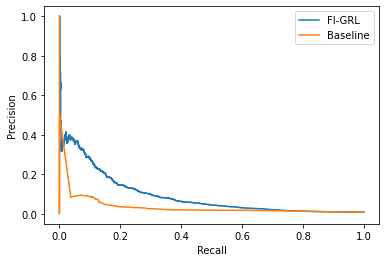

In [23]:
inductive_labels = df.loc[figrl_inductive_emb.index]['LABEL']

pr_curve(predictions, inductive_labels, "FI-GRL")

pr_curve(baseline_predictions, inductive_labels, "Baseline")